#### Thanks to:
- Amira Adel Foda (intake 42 - smart village branch - group 2)
- Asmaa Said (intake 42 - smart village branch - group 2)
- Marawan Mohamed (intake 42 - Alex. branch - group 2)


#Ai- Smart
###Ahmed Rabie Galal Taha
###Ehab Nabil Fathy

### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

In [2]:
!pip install google.colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.6 MB/s eta 0:00:00


### Required Libraries

In [3]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
import re


### Downloading Data

In [ ]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [5]:
!wget http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

--2023-02-21 21:30:22--  http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip
Resolving www.cbsr.ia.ac.cn (www.cbsr.ia.ac.cn)... 159.226.21.60
Connecting to www.cbsr.ia.ac.cn (www.cbsr.ia.ac.cn)|159.226.21.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87413900 (83M) [application/x-zip-compressed]
Saving to: ‘AFLW2000-3D.zip.1’

AFLW2000-3D.zip.1   100%[===================>]  83.36M   311KB/s    in 4m 43s  

2023-02-21 21:35:05 (302 KB/s) - ‘AFLW2000-3D.zip.1’ saved [87413900/87413900]



#Extract Data

In [6]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile(r'/content/AFLW2000-3D.zip.1'):
   !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
   !unzip /content/AFLW2000-3D.zip.1

# Prepare Data features and labels

---



In [7]:

prime_featuresX=[]
prime_featuresY=[]

labels=[]
face_mesh = mediapipe.solutions.face_mesh.FaceMesh()

for fileName in sorted(glob.glob('/content/AFLW2000/*.jpg')):
  fileName_mat=re.sub(".jpg",".mat",fileName)
  mat_file = sio.loadmat(fileName_mat)
  # loading image and its correspinding mat file
  # loading the image
  image=cv2.imread(fileName)
  # processing the face to extract the landmark points (468 point) for each x,y,z
  results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    # looping over the faces in the image
    for face in results.multi_face_landmarks:
      x0= []
      y0= [] 
      for landmark in face.landmark:
        x = landmark.x
        y = landmark.y
        # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
        shape = image.shape

        relative_x = int(x * shape[1])
        relative_y = int(y * shape[0])
        x0.append(relative_x)
        y0.append(relative_y)
        
      labels.append(mat_file ["Pose_Para"][0][:3])

      prime_featuresX.append(x0)
      prime_featuresY.append(y0)

prime_featuresX= np.array(prime_featuresX)
prime_featuresY= np.array(prime_featuresY)
x_center = prime_featuresX - prime_featuresX[:,1].reshape(-1,1)
y_center = prime_featuresY - prime_featuresY[:,1].reshape(-1,1)

d = np.linalg.norm(np.array((prime_featuresX[:, 10],prime_featuresY[:, 10])) - np.array((prime_featuresX[:, 152],prime_featuresY[:, 152])),axis = 0).reshape(-1,1)
prime_featuresX = x_center / d
prime_featuresY = y_center / d

In [8]:
prime_featuresX.shape

(1792, 468)

In [9]:
prime_featuresY.shape

(1792, 468)

# Show data in dataframe

In [10]:
dfX = pd.DataFrame(prime_featuresX)
dfY = pd.DataFrame(prime_featuresY)

df = pd.concat([dfX , dfY], axis = 1)
df

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,-0.008347,0.0,0.000000,-0.020868,0.000000,0.008347,0.025041,-0.237893,0.033388,0.037562,...,0.004174,-0.008347,-0.004174,0.008347,0.012521,-0.287975,-0.275455,-0.258760,-0.313017,-0.329711
1,0.059095,0.0,0.068945,0.029548,-0.004925,0.019698,0.098492,0.019698,0.123115,0.123115,...,0.024623,0.014774,0.039397,0.024623,0.029548,-0.221608,-0.211758,-0.201909,-0.216683,-0.246231
2,0.096595,0.0,0.071175,-0.005084,-0.015252,-0.010168,0.025420,-0.045755,0.025420,0.015252,...,0.015252,0.000000,0.010168,0.015252,0.020336,-0.249113,-0.233861,-0.223693,-0.274533,-0.305037
3,0.077190,0.0,0.048244,-0.053068,-0.014473,-0.024122,-0.033771,-0.231571,-0.057893,-0.077190,...,-0.004824,-0.024122,-0.038595,0.000000,0.004824,-0.313585,-0.299112,-0.279815,-0.395600,-0.419722
4,0.111001,0.0,0.095144,0.015857,-0.015857,0.000000,0.068715,0.058143,0.074001,0.058143,...,0.010572,-0.005286,0.015857,0.010572,0.021143,-0.259002,-0.237859,-0.227287,-0.290717,-0.317145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1787,-0.030922,0.0,-0.026505,-0.044175,0.004417,0.000000,-0.026505,-0.348981,-0.030922,-0.026505,...,0.004417,-0.008835,0.004417,0.013252,0.017670,-0.251796,-0.242961,-0.229709,-0.287136,-0.300388
1788,-0.048023,0.0,-0.034926,-0.043657,0.004366,0.000000,-0.021828,-0.340524,-0.026194,-0.021828,...,0.004366,-0.008731,0.000000,0.013097,0.013097,-0.279404,-0.261941,-0.248844,-0.309964,-0.331792
1789,-0.038722,0.0,-0.019361,0.000000,0.014521,0.024201,0.048402,-0.208128,0.072603,0.091964,...,0.024201,0.014521,0.043562,0.024201,0.033881,-0.198448,-0.193608,-0.188767,-0.174247,-0.188767
1790,0.000000,0.0,0.008592,-0.012888,0.004296,0.012888,0.034368,-0.240574,0.047256,0.051552,...,0.012888,0.004296,0.017184,0.017184,0.021480,-0.262054,-0.249166,-0.240574,-0.266350,-0.274942


In [11]:
labels = np.array(labels)
labels = pd.DataFrame(labels, columns = ['pitch', 'yaw', 'roll'])
print("labels shape:" , labels.shape)

labels shape: (1792, 3)


In [12]:
labels

,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.882169,1.198004,-1.033374
...,...,...,...
1787,-0.306358,-0.283822,0.038554
1788,-0.367547,-0.429723,0.122791
1789,-0.156035,0.567114,-0.108536
1790,-0.197102,-0.070430,0.105118


# Normalize Data (Center all points to nose)

In [13]:
def normalizeImage(image):
  prime_featuresX=[]
  prime_featuresY=[]
  nose=[]

  face_mesh = mediapipe.solutions.face_mesh.FaceMesh()

  # processing the face to extract the landmark points (468 point) for each x,y,z
  results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  if results.multi_face_landmarks != None:
    # looping over the faces in the image
    for face in results.multi_face_landmarks:
      x0= []
      y0= [] 
      for landmark in face.landmark:
        x = landmark.x
        y = landmark.y
        # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
        shape = image.shape

        relative_x = int(x * shape[1])
        relative_y = int(y * shape[0])
        x0.append(relative_x)
        y0.append(relative_y)

      prime_featuresX.append(x0)
      prime_featuresY.append(y0)

  prime_featuresX= np.array(prime_featuresX)
  print(prime_featuresX.shape)
  prime_featuresY= np.array(prime_featuresY)
  x_center = prime_featuresX - prime_featuresX[:,1].reshape(-1,1)  #Nose
  y_center = prime_featuresY - prime_featuresY[:,1].reshape(-1,1)
  nose.append(prime_featuresX[:,1].reshape(-1,1))
  nose.append(prime_featuresY[:,1].reshape(-1,1))

  d = np.linalg.norm(np.array((prime_featuresX[:, 10],prime_featuresY[:, 10])) - np.array((prime_featuresX[:, 152],prime_featuresY[:, 152])),axis = 0).reshape(-1,1)
  prime_featuresX = x_center / d
  prime_featuresY = y_center / d
  return pd.concat([pd.DataFrame(prime_featuresX) , pd.DataFrame(prime_featuresY)], axis = 1),np.array(nose).reshape(2,)

#Train Test Split

In [14]:
#multi labels
x_train, x_valid, y_train, y_valid = train_test_split(df, labels, test_size=0.2, random_state=42, shuffle=True)
print(x_valid.shape)
print(y_valid.shape)

(359, 936)
(359, 3)


In [15]:
#Shape of features
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(1433, 936)
(1433, 3)
(359, 936)
(359, 3)


#Models

**Sacler**

In [17]:
scalar = preprocessing.StandardScaler()
x_train = scalar.fit_transform(x_train)
x_valid = scalar.transform(x_valid)
pca = PCA(n_components=.999)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_valid = pca.transform(x_valid)

**Random Forest Regressor**

In [18]:
clf = RandomForestRegressor()
clf = MultiOutputRegressor(clf)
clf.fit(x_train, y_train)
clf.score(x_train, y_train)
pred = clf.predict(x_valid)
print("Training Score: ", clf.score(x_train, y_train))
print("Validation Score: ", clf.score(x_valid, y_valid))
print("Train Error: ",mean_absolute_error(clf.predict(x_train),y_train))
print("Validation Error: ",mean_absolute_error(clf.predict(x_valid),y_valid))

Training Score:  0.9454869730693694
Validation Score:  0.6398950380838277
Train Error:  0.0440466250578726
Validation Error:  0.12397170430676929


**Ridge**

In [19]:
clf = Ridge(alpha=1)
clf = MultiOutputRegressor(clf)
clf.fit(x_train, y_train)
clf.score(x_train, y_train)
pred = clf.predict(x_valid)
print("Training Score: ", clf.score(x_train, y_train))
print("Validation Score: ", clf.score(x_valid, y_valid))
print("Train Error: ",mean_absolute_error(clf.predict(x_train),y_train))
print("Validation Error: ",mean_absolute_error(clf.predict(x_valid),y_valid))

Training Score:  0.6718978858275362
Validation Score:  0.6572477323141336
Train Error:  0.1122573913289817
Validation Error:  0.1253765887805043


**SVR**

In [20]:
clf =SVR()
clf = MultiOutputRegressor(clf)
clf.fit(x_train, y_train)
clf.score(x_train, y_train)
pred = clf.predict(x_valid)
print("Training Score: ", clf.score(x_train, y_train))
print("Validation Score: ", clf.score(x_valid, y_valid))
print("Train Error: ",mean_absolute_error(clf.predict(x_train),y_train))
print("Validation Error: ",mean_absolute_error(clf.predict(x_valid),y_valid))

Training Score:  0.7218923747174083
Validation Score:  0.6720489221460912
Train Error:  0.09500894090961647
Validation Error:  0.11848122031606086


**SVR using hyper parameters**

In [21]:
clf =SVR(kernel='rbf', C=2, epsilon=0.05, degree=2, tol=0.00001)
clf = MultiOutputRegressor(clf)
clf.fit(x_train, y_train)
clf.score(x_train, y_train)
pred = clf.predict(x_valid)
print("Training Score: ", clf.score(x_train, y_train))
print("Validation Score: ", clf.score(x_valid, y_valid))
print("Train Error: ",mean_absolute_error(clf.predict(x_train),y_train))
print("Validation Error: ",mean_absolute_error(clf.predict(x_valid),y_valid))

Training Score:  0.7489931853997769
Validation Score:  0.6827598370617173
Train Error:  0.0799902076034936
Validation Error:  0.11323190351320127


#Save Model

In [22]:
import pickle

# assume `model` is your trained machine learning model
model = clf

# save the model to a file named "model.pkl"
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

#Draw Axis

In [23]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

#Test image


(1, 468)


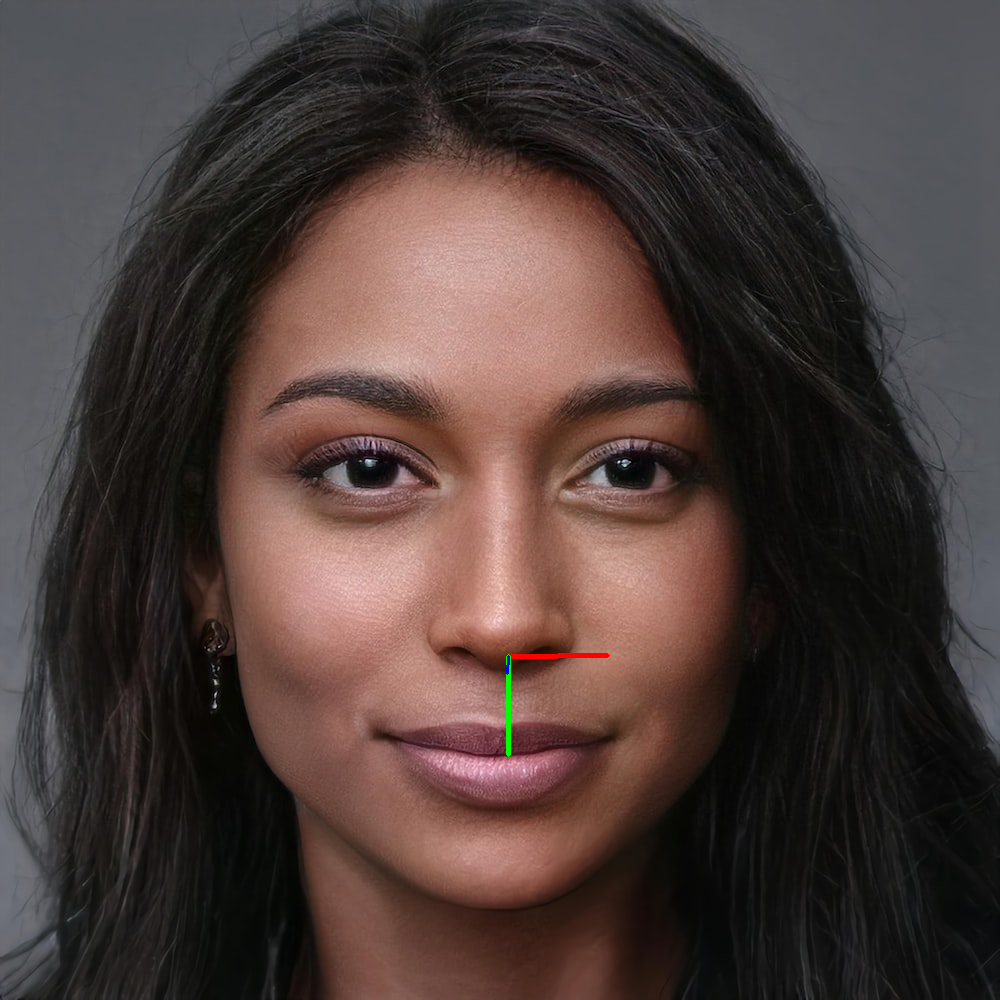

In [25]:
testImg = '/content/photo-1597223557154-721c1cecc4b0.jpg'
img = cv2.imread(testImg)

#Landmarks of image
x_test,nose = normalizeImage(img)

# predict angles
x=scalar.transform(x_test)
x=pca.transform(x)
pred = clf.predict(x)

# draw axis
cv2_imshow(draw_axis(img, pred[0][0], pred[0][1], pred[0][2], nose[0], nose[1]))

(1, 468)


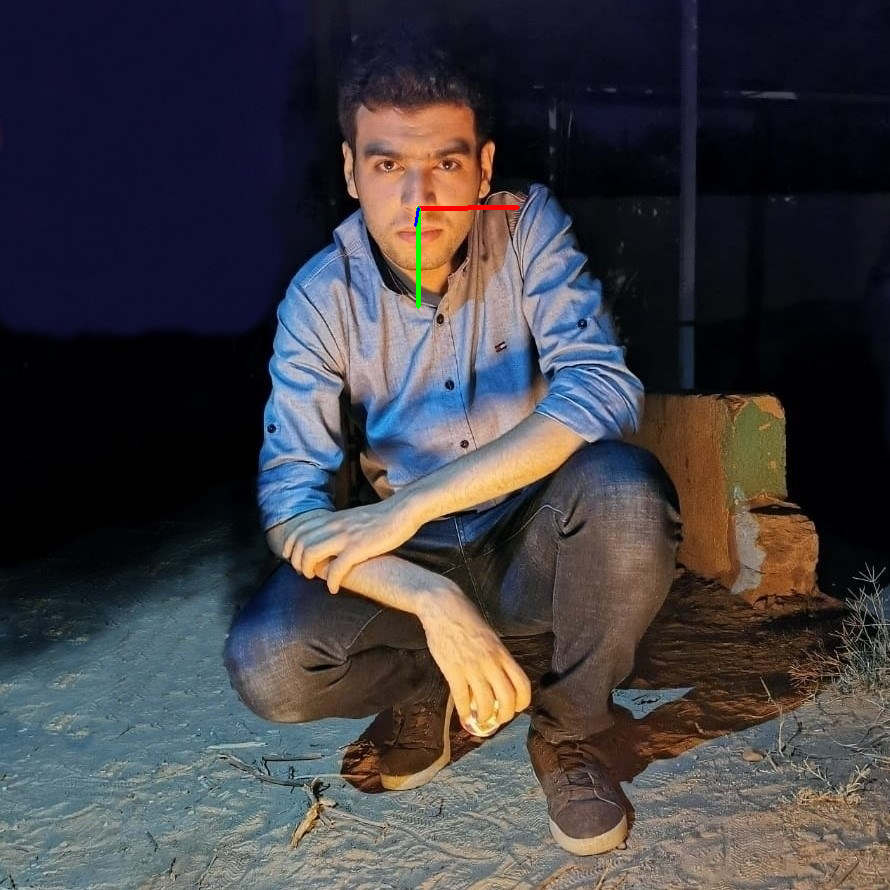

In [27]:
testImg = '/content/95838281_2007768822681079_6111269133951696896_n (1).jpg'
img = cv2.imread(testImg)

#Landmarks of image
x_test,nose = normalizeImage(img)

# predict angles
x=scalar.transform(x_test)
x=pca.transform(x)
pred = clf.predict(x)
# draw axis
cv2_imshow(draw_axis(img, pred[0][0], pred[0][1], pred[0][2], nose[0], nose[1]))

#Generate Video with angels (Test)

In [ ]:
cap = cv2.VideoCapture('/content/Untitled.mp4')
frame_rate = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('out.mp4', fourcc, frame_rate, (width, height))
while True:
        try:
        # Read the next frame from the video
            ret, frame = cap.read()
            if not ret:
              break
            #frame = cv2.flip(frame, 1)
            x_test,nose = normalizeImage(frame)
            #x=scalar.transform(x_test)
            x=scalar.transform(x_test)
            pred = clf.predict(x)
            frame=draw_axis(frame, pred[0][0], pred[0][1], pred[0][2], nose[0], nose[1])
            out.write(frame)
        except:
          pass             

# Release the video capture and output object
cap.release()
out.release()